# MLR project from predicting price of King County, WA homes

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sstats
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot

## Read in, clean, and examine data

In [13]:
data = pd.read_csv('King County Homes.csv')
data = data.drop(labels='ID', axis=1)

In [14]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,0,98178,47.5112,-122.257,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1,98125,47.7210,-122.319,1690,7639
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,0,98028,47.7379,-122.233,2720,8062
3,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,0,98074,47.6168,-122.045,1800,7503
4,1230000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,0,98053,47.6561,-122.005,4760,101930


### Removing features

Because I'm not using any tree-based models--longitude, latitude, and zip would  just confuse the model.

In [15]:
data = data.drop(labels=['long', 'lat', 'zipcode'], axis=1)

In [16]:
data.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,renovated,sqft_living15,sqft_lot15
0,221900,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,0,1340,5650


### Checking for null values

In [17]:
data.isnull().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
renovated        False
sqft_living15    False
sqft_lot15       False
dtype: bool

Sweet. No NULL values.

### Summary statistics

In [18]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,renovated,sqft_living15,sqft_lot15
count,1.618700e+04,16187.000000,16187.000000,16187.000000,1.618700e+04,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000,16187.000000
mean,5.428020e+05,3.374374,2.117038,2083.711435,1.506874e+04,1.494965,0.007599,0.243467,3.408785,7.661395,1790.829616,292.881819,1970.847779,83.237845,0.041700,1989.630815,12677.886637
std,3.696331e+05,0.944437,0.770570,921.259500,4.234745e+04,0.541742,0.086841,0.783238,0.650925,1.181719,829.774083,445.016165,29.477889,399.052829,0.199909,688.003602,27553.569520
min,7.500000e+04,0.000000,0.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,0.000000,399.000000,651.000000
25%,3.246235e+05,3.000000,1.750000,1420.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,0.000000,1490.000000,5100.000000
50%,4.510000e+05,3.000000,2.250000,1920.000000,7.600000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,0.000000,1840.000000,7601.000000
75%,6.488760e+05,4.000000,2.500000,2550.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,570.000000,1997.000000,0.000000,0.000000,2370.000000,10080.000000
max,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,1.000000,6210.000000,871200.000000


Checking the mean of price to compare to MAE of models

In [19]:
data['price'].mean()

542802.0316920986

In [20]:
data.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,renovated,sqft_living15,sqft_lot15
price,1.000000,0.311239,0.527026,0.703301,0.089339,0.254886,0.245270,0.405373,0.038549,0.668332,0.606761,0.324591,0.052570,0.129029,0.128697,0.582507,0.080353
bedrooms,0.311239,1.000000,0.512142,0.576626,0.030339,0.170866,-0.012842,0.082484,0.033844,0.355334,0.475253,0.307560,0.148135,0.024627,0.024312,0.388414,0.030401
bathrooms,0.527026,0.512142,1.000000,0.759303,0.084095,0.499758,0.053183,0.189453,-0.119656,0.666109,0.689253,0.286710,0.506138,0.054246,0.053742,0.566635,0.084344
sqft_living,0.703301,0.576626,0.759303,1.000000,0.165690,0.350268,0.092842,0.289076,-0.056668,0.764177,0.875942,0.436896,0.317272,0.058535,0.058260,0.753811,0.176640
sqft_lot,0.089339,0.030339,0.084095,0.165690,1.000000,-0.008777,0.020222,0.076584,-0.009068,0.110650,0.179020,0.009207,0.046813,0.004050,0.004147,0.137406,0.709769
floors,0.254886,0.170866,0.499758,0.350268,-0.008777,1.000000,0.016572,0.023128,-0.262221,0.455884,0.520756,-0.245885,0.488019,0.007183,0.007073,0.275003,-0.014412
waterfront,0.245270,-0.012842,0.053183,0.092842,0.020222,0.016572,1.000000,0.396077,0.014995,0.070828,0.064436,0.072053,-0.026289,0.095262,0.095628,0.076862,0.028964
view,0.405373,0.082484,0.189453,0.289076,0.076584,0.023128,0.396077,1.000000,0.046410,0.258219,0.171496,0.278665,-0.054452,0.105876,0.106007,0.284617,0.071818
condition,0.038549,0.033844,-0.119656,-0.056668,-0.009068,-0.262221,0.014995,0.046410,1.000000,-0.143806,-0.156002,0.173567,-0.362449,-0.056981,-0.056466,-0.091794,-0.003400
grade,0.668332,0.355334,0.666109,0.764177,0.110650,0.455884,0.070828,0.258219,-0.143806,1.000000,0.757680,0.169214,0.443152,0.019920,0.019499,0.711729,0.117174


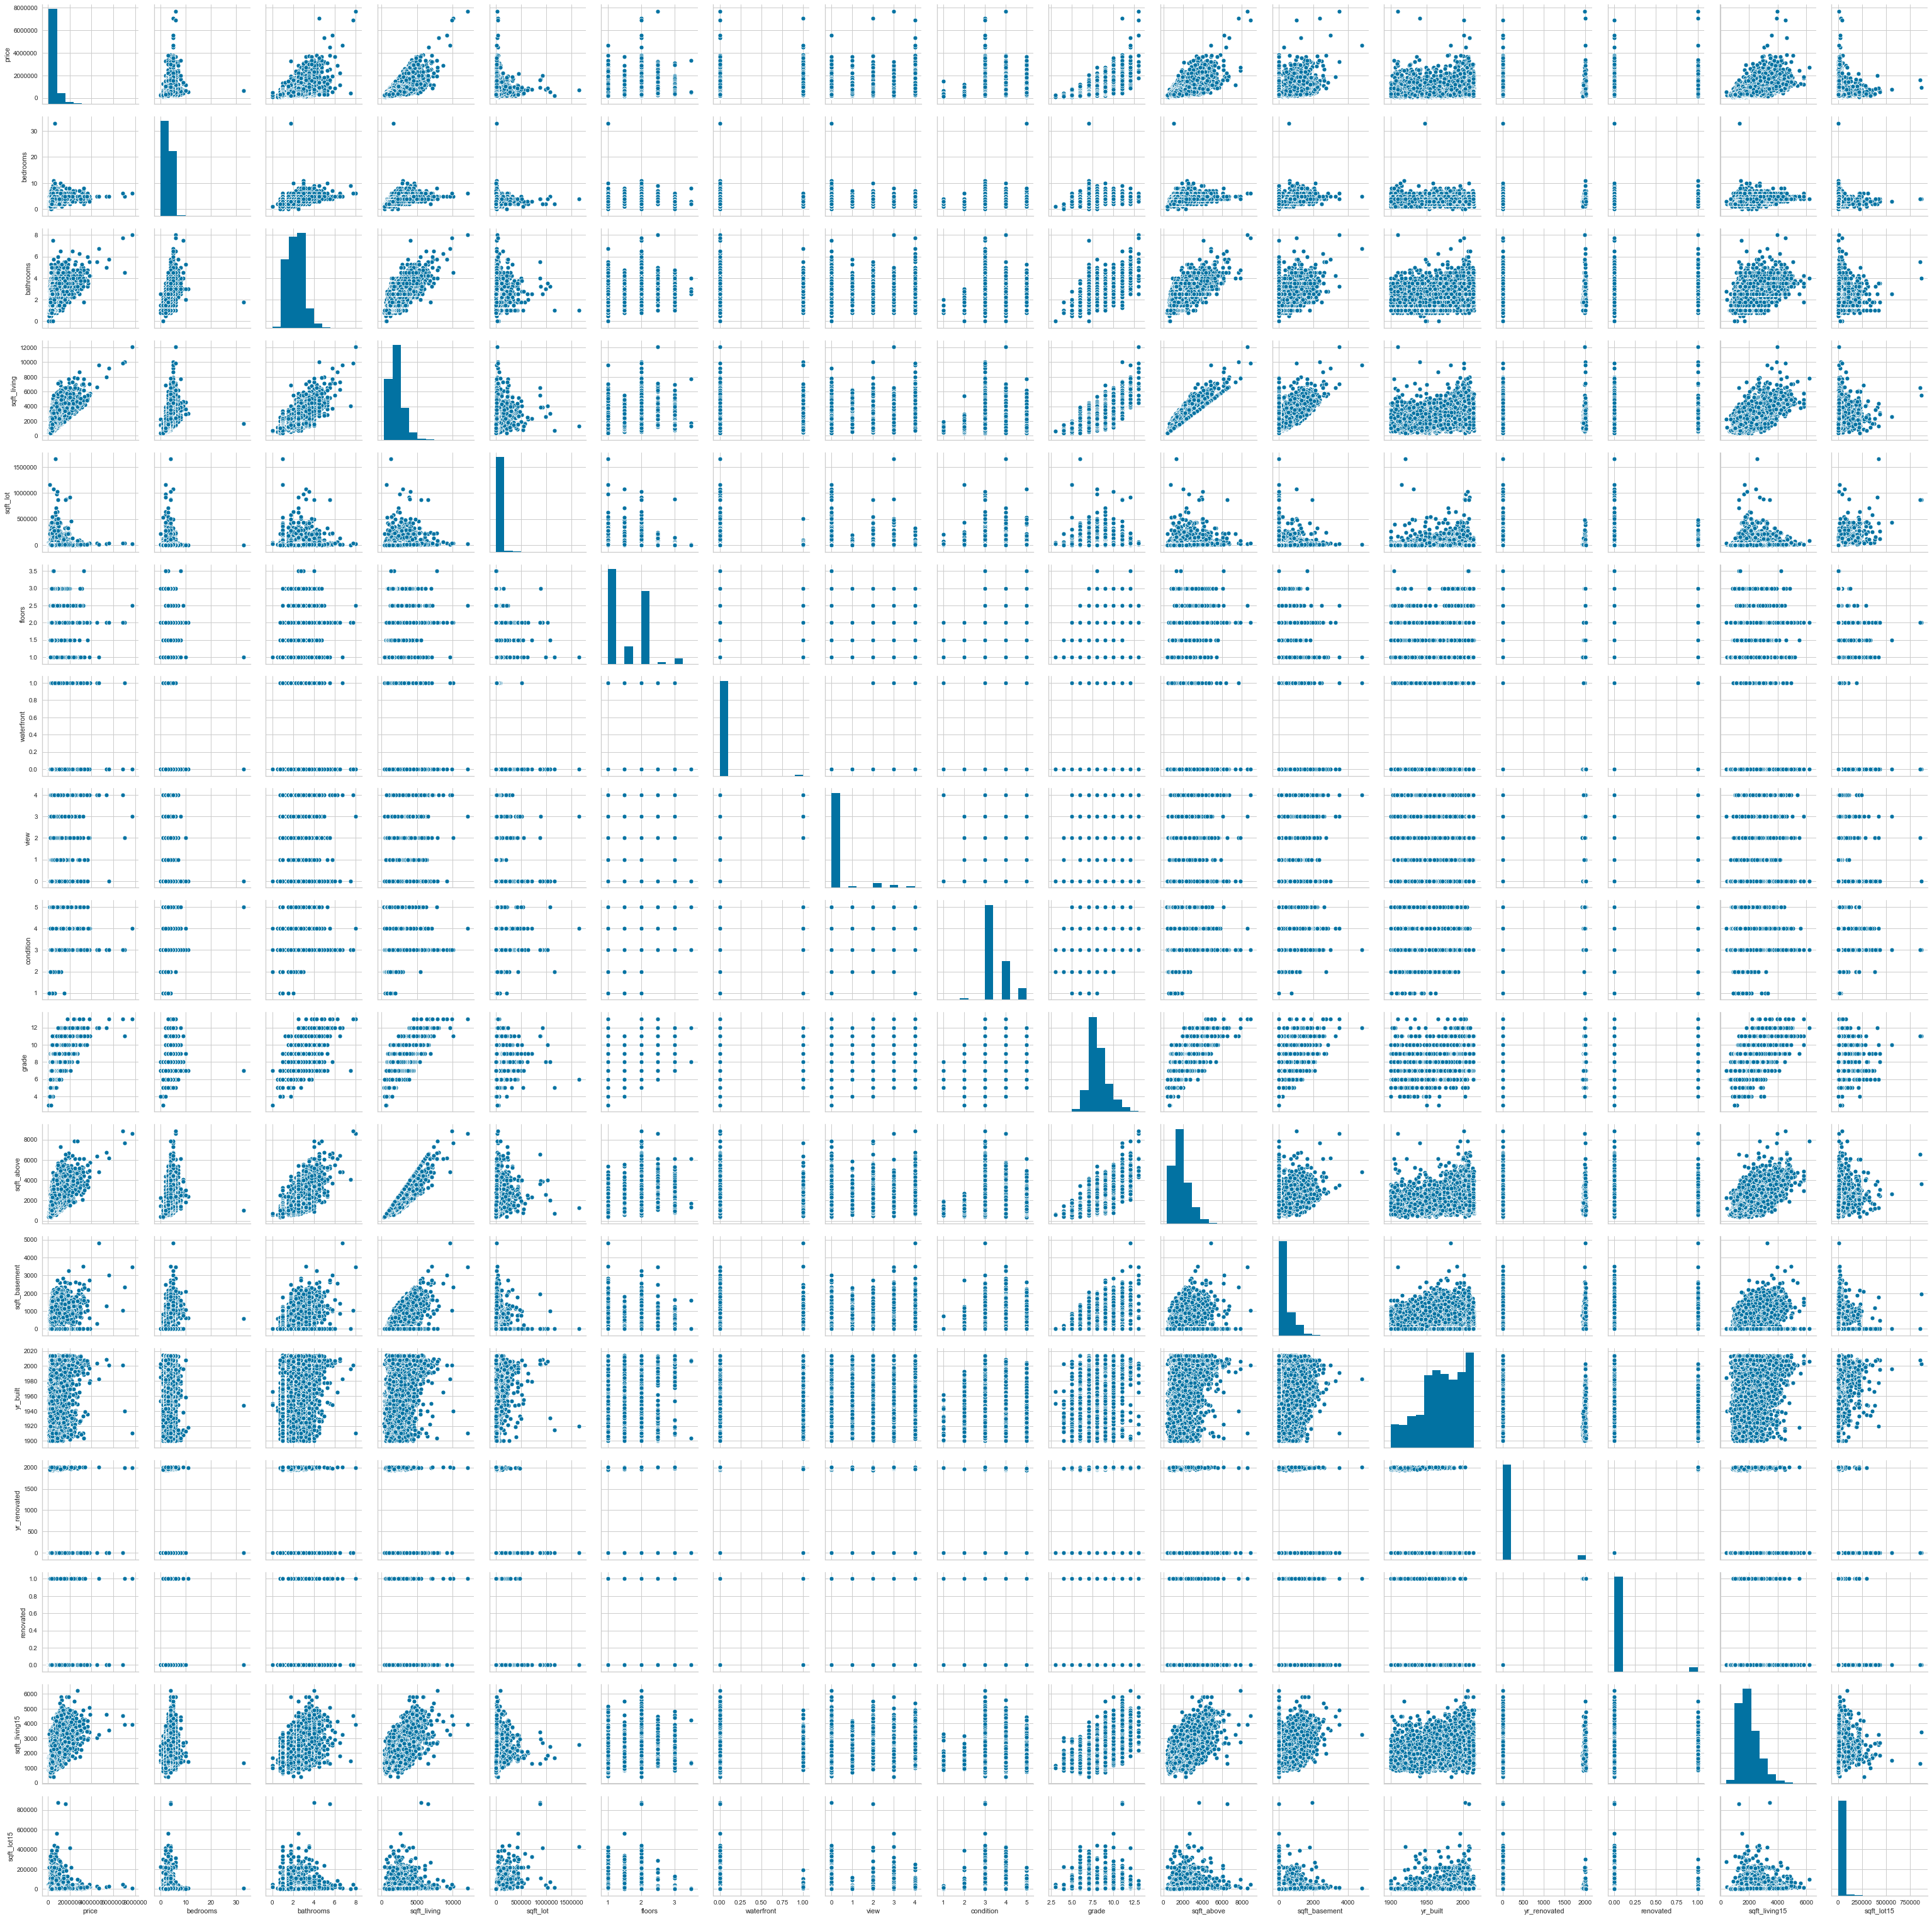

In [23]:
sns.pairplot(data)

## Split data into target and predictors

In [24]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

In [25]:
X.shape, y.shape

((16187, 16), (16187,))

In [29]:
X.head(1)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,renovated,sqft_living15,sqft_lot15
0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,0,1340,5650


In [32]:
y.head(1)

0    221900
Name: price, dtype: int64

## Split data into training and test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, y_train.shape

((12949, 16), (12949,))

# Cross-validated dummy regressor for baseline model error

In [45]:
dummyreg = DummyRegressor(strategy='mean')
scores = cross_val_score(dummyreg, X, y,
                         scoring=metrics.make_scorer(metrics.mean_absolute_error),
                         cv=5)
scores

array([237472.60747177, 238184.50756892, 229002.01176648, 238158.57318789,
       237013.63527984])

In [47]:
print("Average Mean Absolute Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Average Mean Absolute Error: 235966.27 (+/- 7019.61)


This is a horrible MAE!!! Being that our mean is 542802 dollars, having an average price error of 235966 dollars is pretty terrible. Let's see how a standard multiple linear regression model does without any feature selection or feature transformations.

# Base MLR model

In [164]:
mlr1 = LinearRegression()
scores = cross_val_score(mlr1, X, y,
                         scoring=metrics.make_scorer(metrics.mean_absolute_error),
                         cv=5)
mlr1.fit(X_train, y_train)
print("Average Mean Absolute Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Average Mean Absolute Error: 141855.23 (+/- 8407.33)


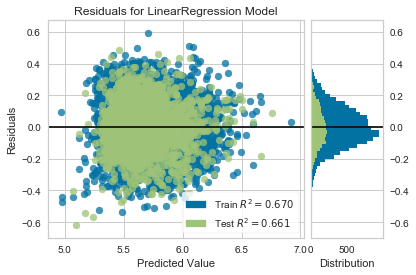

In [165]:
visualizer = ResidualsPlot(mlr1)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

# MLR normalized

In [166]:
mlr2 = LinearRegression(normalize=True)
scores = cross_val_score(mlr2, X, y,
                         scoring=metrics.make_scorer(metrics.mean_absolute_error),
                         cv=5)
mlr2.fit(X_train, y_train)
print("Average Mean Absolute Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Average Mean Absolute Error: 141860.65 (+/- 8394.38)


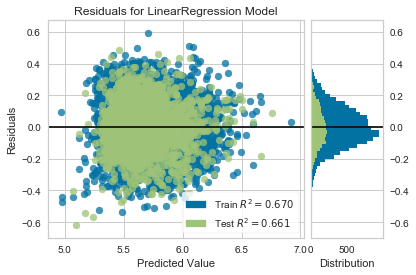

In [167]:
visualizer = ResidualsPlot(mlr2)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

# MLR with Recursive Feature Selection

In [168]:
m = feature_selection.RFECV(LinearRegression(normalize=True), cv=5)

m.fit(X, y)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=True),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [169]:
m.score(X, y)

0.652659210354107

In [170]:
m.support_

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [171]:
m.ranking_

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [174]:
metrics.mean_absolute_error(y_test, m.predict(X_test))

235427.88012998947

# MLR with log10(price)

In [146]:
data2 = data.copy()
data2['price'] = (np.log10(data2['price']))
X2 = data2.iloc[:, 1:]
y2 = data2.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size = 0.2, random_state = 0)

mlr3 = LinearRegression()
scores = cross_val_score(mlr3, X2, y2,
                         scoring=metrics.make_scorer(metrics.mean_absolute_error),
                         cv=5)
scores


array([0.10787675, 0.10942473, 0.10731636, 0.10875474, 0.10425242])

In [147]:
mlr3.fit(X_train, y_train)

metrics.mean_absolute_error(10**y_test, 10**mlr3.predict(X_test))

134867.42886106006

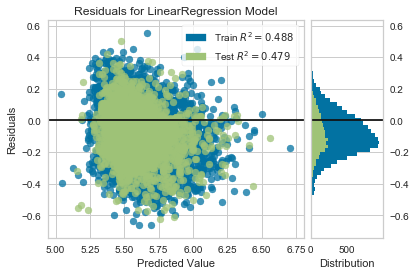

In [151]:
visualizer2 = ResidualsPlot(mlr3)
visualizer2.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer2.score(X_test, y_test)  # Evaluate the model on the test data
visualizer2.show()

It's harder to read the cross-validation results after log transforming the target variable; it is necessary to return the MAE from the test set predictions. 

# MLR with log10(price) and Box-Cox transformations on skewed predictors

In [160]:
data3 = data2.copy()
f = sstats.boxcox(data3['sqft_lot15'])
data3['sqft_lot15'] = f[0]
f2 = sstats.boxcox(data3['sqft_above'])
data3['sqft_above'] = f2[0]
f3 = sstats.boxcox(data3['sqft_living'])
data3['sqft_living'] = f3[0]

X3 = data3.iloc[:, 1:]
y3 = data3.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.2,
                                                    random_state = 0)
mlr4 = LinearRegression()
scores = cross_val_score(mlr4, X3, y3,
                         scoring=metrics.make_scorer(metrics.mean_absolute_error),
                         cv=5)
scores

array([0.10623744, 0.10683637, 0.10459192, 0.1062774 , 0.10258985])

In [161]:
mlr4.fit(X_train, y_train)

metrics.mean_absolute_error(10**y_test, 10**mlr4.predict(X_test))

130470.19222297132

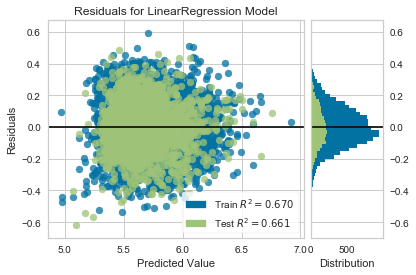

In [162]:
visualizer3 = ResidualsPlot(mlr4)
visualizer3.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer3.score(X_test, y_test)  # Evaluate the model on the test data
visualizer3.show()

# It looks like the best MLR model to use is the last model. However, it's hard to say as we can't really look at the cross validation scores of the transformed models. 

## So the safest bet is probably to go with the normalized MLR model. I'm very surprised that the Recursive Feature Selection has such a hard time... perhaps my scoring metric choice?